# Did students’ rate of late submissions increase after COVID and by how much?

In [34]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
import datetime
import matplotlib.ticker as ticker
import sys
sys.path.insert(0, '/home/jenny/remote_learning_code_Spring_2017-2020')
from utils import parse_args


sys.argv = ['-f']
args = parse_args()

term_20 = args.semester_2020_Spring
start_date_20 = args.start_date_2020_Spring
remote_date_20 = args.remote_date_2020_Spring
end_date_20 = args.end_date_2020_Spring

term_19 = args.semester_2019_Spring
start_date_19 = args.start_date_2019_Spring
cutoff_date_19 = args.cutoff_date_2019_Spring
end_date_19 = args.end_date_2019_Spring

term_18 = args.semester_2018_Spring
start_date_18 = args.start_date_2018_Spring
cutoff_date_18 = args.cutoff_date_2018_Spring
end_date_18 = args.end_date_2018_Spring

term_17 = args.semester_2017_Spring
start_date_17 = args.start_date_2017_Spring
cutoff_date_17 = args.cutoff_date_2017_Spring
end_date_17 = args.end_date_2017_Spring

# load students
f = open('../user_id_groups.pkl', 'rb')
user = pickle.load(f)
students = user['student']

In [35]:
submission = pd.read_csv(args.submissions, sep='\t', header=0)
submission['submitted_at'] = pd.to_datetime(submission['submitted_at'], format='%Y-%m-%d %H:%M:%S.%f')
assignments = pd.read_csv(args.assignments, sep='\t', header=0)
assignments['asn_due_at'] = pd.to_datetime(assignments['asn_due_at'], format='%Y-%m-%d %H:%M:%S.%f')
assignments_overrides_users = pd.read_csv(args.assignments_overrides_user_rollups, sep='\t', header=0)
assignments_overrides_users['due_at'] = pd.to_datetime(assignments_overrides_users['due_at'], format='%Y-%m-%d %H:%M:%S.%f')

In [36]:
def late_submission(term, start_date, end_date):    
    submission1 = submission.loc[(submission['term_name']==term)&(submission['user_id'].isin(students))&(submission['submitted_at']>=start_date)&(submission['submitted_at']<=end_date)]

    assignments1 = assignments.loc[assignments['workflow_state']=='published', ['assignment_id', 'asn_due_at', 'asn_updated_at']]  # no duplicate exists
    assignments1 = assignments1.loc[assignments1['asn_due_at'].notnull()]
    
    submission1 = pd.merge(submission1, assignments1, on='assignment_id', how='inner')
   
    #assignments_overrides_users1 = assignments_overrides_users.loc[assignments_overrides_users['workflow_state']=='active']
    assignments_overrides_users1 = assignments_overrides_users.loc[assignments_overrides_users['term_name']==term]
    assignments_overrides_users1 = assignments_overrides_users1.loc[assignments_overrides_users1['due_at'].notnull(), ['assignment_id', 'user_id', 'due_at']]
    submission1 = pd.merge(submission1, assignments_overrides_users1, on=['assignment_id', 'user_id'], how='left')
   
    submission1['due_date'] = submission1.apply(lambda x: x['due_at'] if x['due_at'] and x['due_at']>x['asn_due_at'] else x['asn_due_at'], axis=1)
    
    #submission1['late_submssion'] = submission1.apply(lambda x: 1 if x['due_date']<x['submitted_at'] else 0, axis=1)
    submission1 = submission1.loc[submission1['due_at']>submission1['asn_due_at']]
    submission1['submitted_at'] = pd.to_datetime(submission1['submitted_at'], format='%Y-%m-%d %H:%M:%S.%f')
    submission1['submitted_at'] = submission1['submitted_at'].apply(lambda x: x.date())
    time = submission1.groupby('submitted_at').size().reset_index()
    return time


late_20 = late_submission(term_20, start_date_20, end_date_20)
late_19 = late_submission(term_19, start_date_19, end_date_19)
late_18 = late_submission(term_18, start_date_18, end_date_18)
late_17 = late_submission(term_17, start_date_17, end_date_17)
    

In [37]:
late_20.set_index('submitted_at', inplace=True)
late_19['submitted_at'] = late_19['submitted_at'].apply(lambda x: x.replace(year=2020))
late_19.set_index('submitted_at', inplace=True)
late_18['submitted_at'] = late_18['submitted_at'].apply(lambda x: x.replace(year=2020))
late_18.set_index('submitted_at', inplace=True)
late_17['submitted_at'] = late_17['submitted_at'].apply(lambda x: x.replace(year=2020))
late_17.set_index('submitted_at', inplace=True)

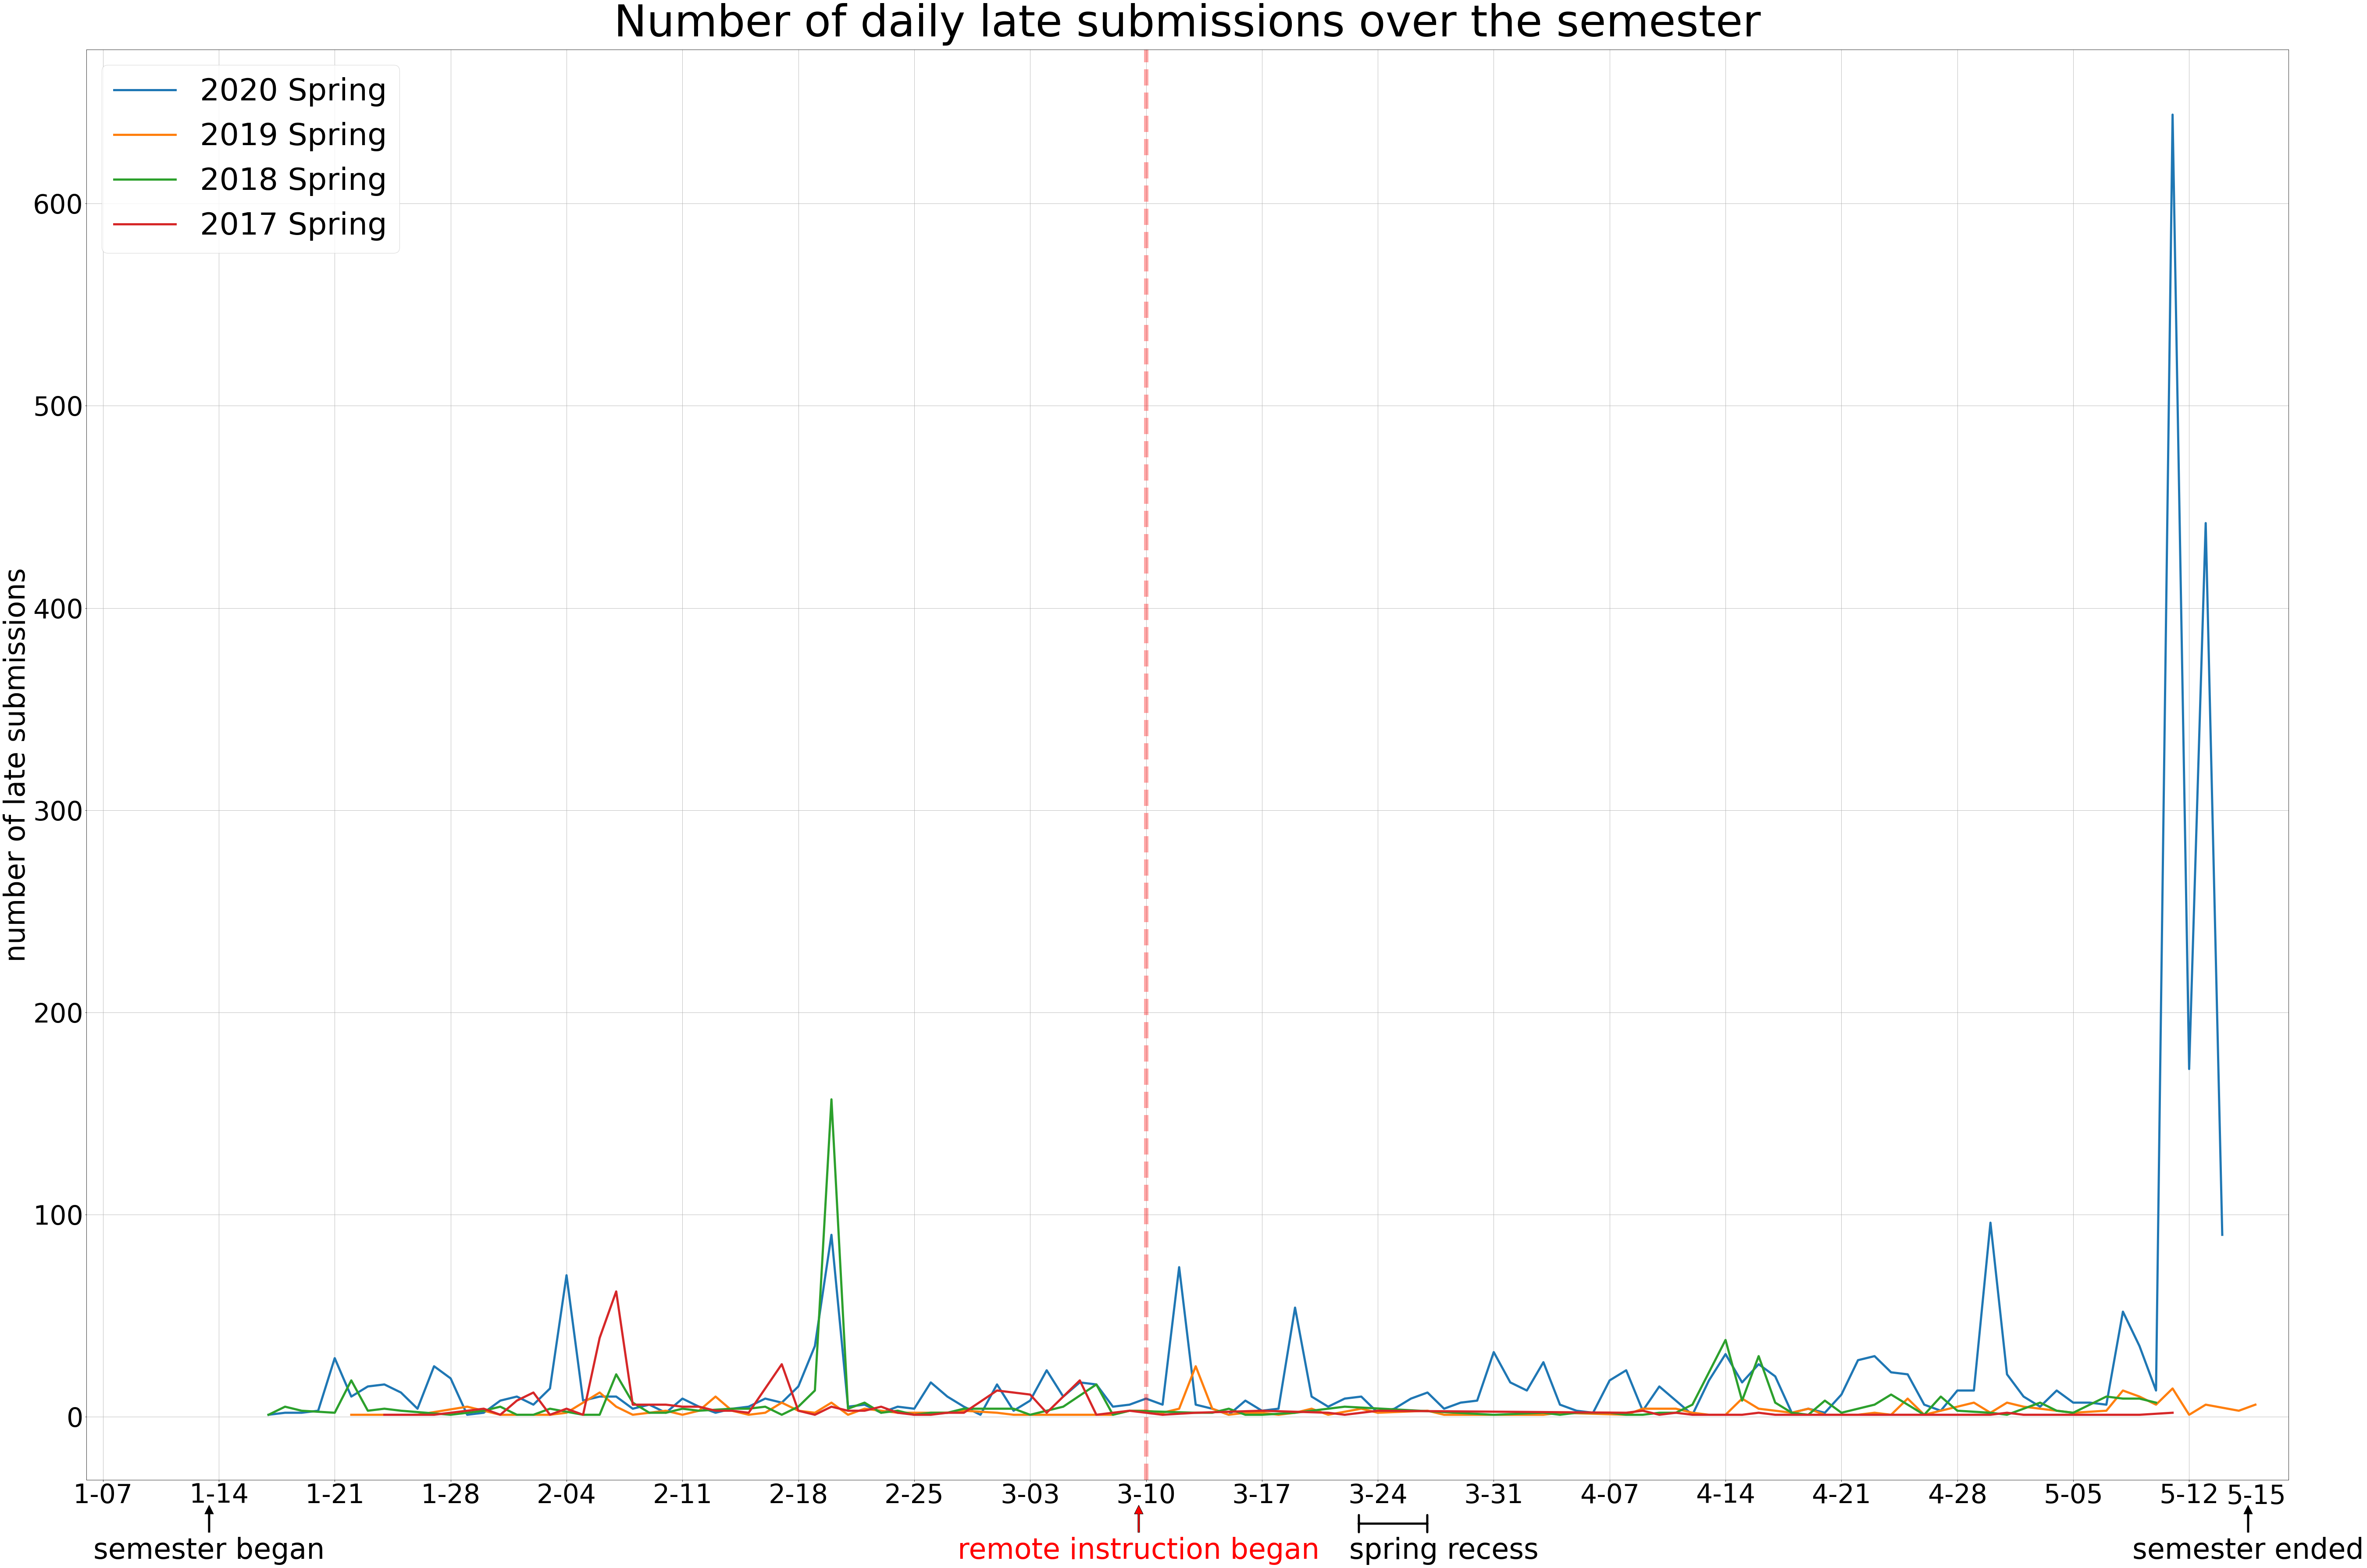

In [38]:

# set x-axis ticks
fig,ax = plt.subplots()
fig.patch.set_facecolor('white')
myFmt = mdates.DateFormatter('%-m-%d')
ax.xaxis.set_major_formatter(myFmt)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.set_xlim([datetime.date(2020, 1, 6), datetime.date(2020, 5, 18)])

plt.plot(late_20, linewidth=5.0, label='2020 Spring')
plt.plot(late_19, linewidth=5.0, label='2019 Spring')
plt.plot(late_18, linewidth=5.0, label='2018 Spring')
plt.plot(late_17, linewidth=5.0, label='2017 Spring')

plt.xticks(fontsize=60)
plt.yticks(fontsize=60)
plt.grid(True)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 90
fig_size[1] = 60
plt.rcParams["figure.figsize"] = fig_size
plt.title('Number of daily late submissions over the semester', fontsize=100, pad=30)
#plt.xlabel('date', fontsize=65, labelpad=120)
plt.ylabel('number of late submissions', fontsize=65)

# annotation on x-axis

ax.annotate('semester began', fontsize=65, xy=(280, -50), xytext=(280, -180), xycoords='axes points', ha='center',
           arrowprops=dict(facecolor='black', shrink=0.1, headlength=20, headwidth=20))
ax.annotate('remote instruction began', color='red', fontsize=65, xy=(2400, -50), xytext=(2400, -180), xycoords='axes points', ha='center', arrowprops=dict(facecolor='red', shrink=0.1, headlength=20, headwidth=20))
ax.annotate('semester ended', fontsize=65, xy=(4930, -50), xytext=(4930, -180), xycoords='axes points', ha='center', arrowprops=dict(facecolor='black', shrink=0.1, headlength=20, headwidth=20))
ax.annotate('5-15', fontsize=60, xy=(4880, -55), xycoords='axes points')

ax.annotate('', fontsize=65, xy=(2900, -100), xytext=(3060, -100),
            xycoords='axes points',
            arrowprops=dict(arrowstyle='|-|,widthA=0.3,widthB=0.3', linewidth=5))
ax.annotate('spring recess', fontsize=65, xy=(2880, -180), xycoords='axes points')
plt.axvline(x=datetime.date(2020, 3, 10), color = 'r', linewidth=10, alpha=0.35, linestyle='--')
plt.legend(prop={'size': 70})
plt.show()

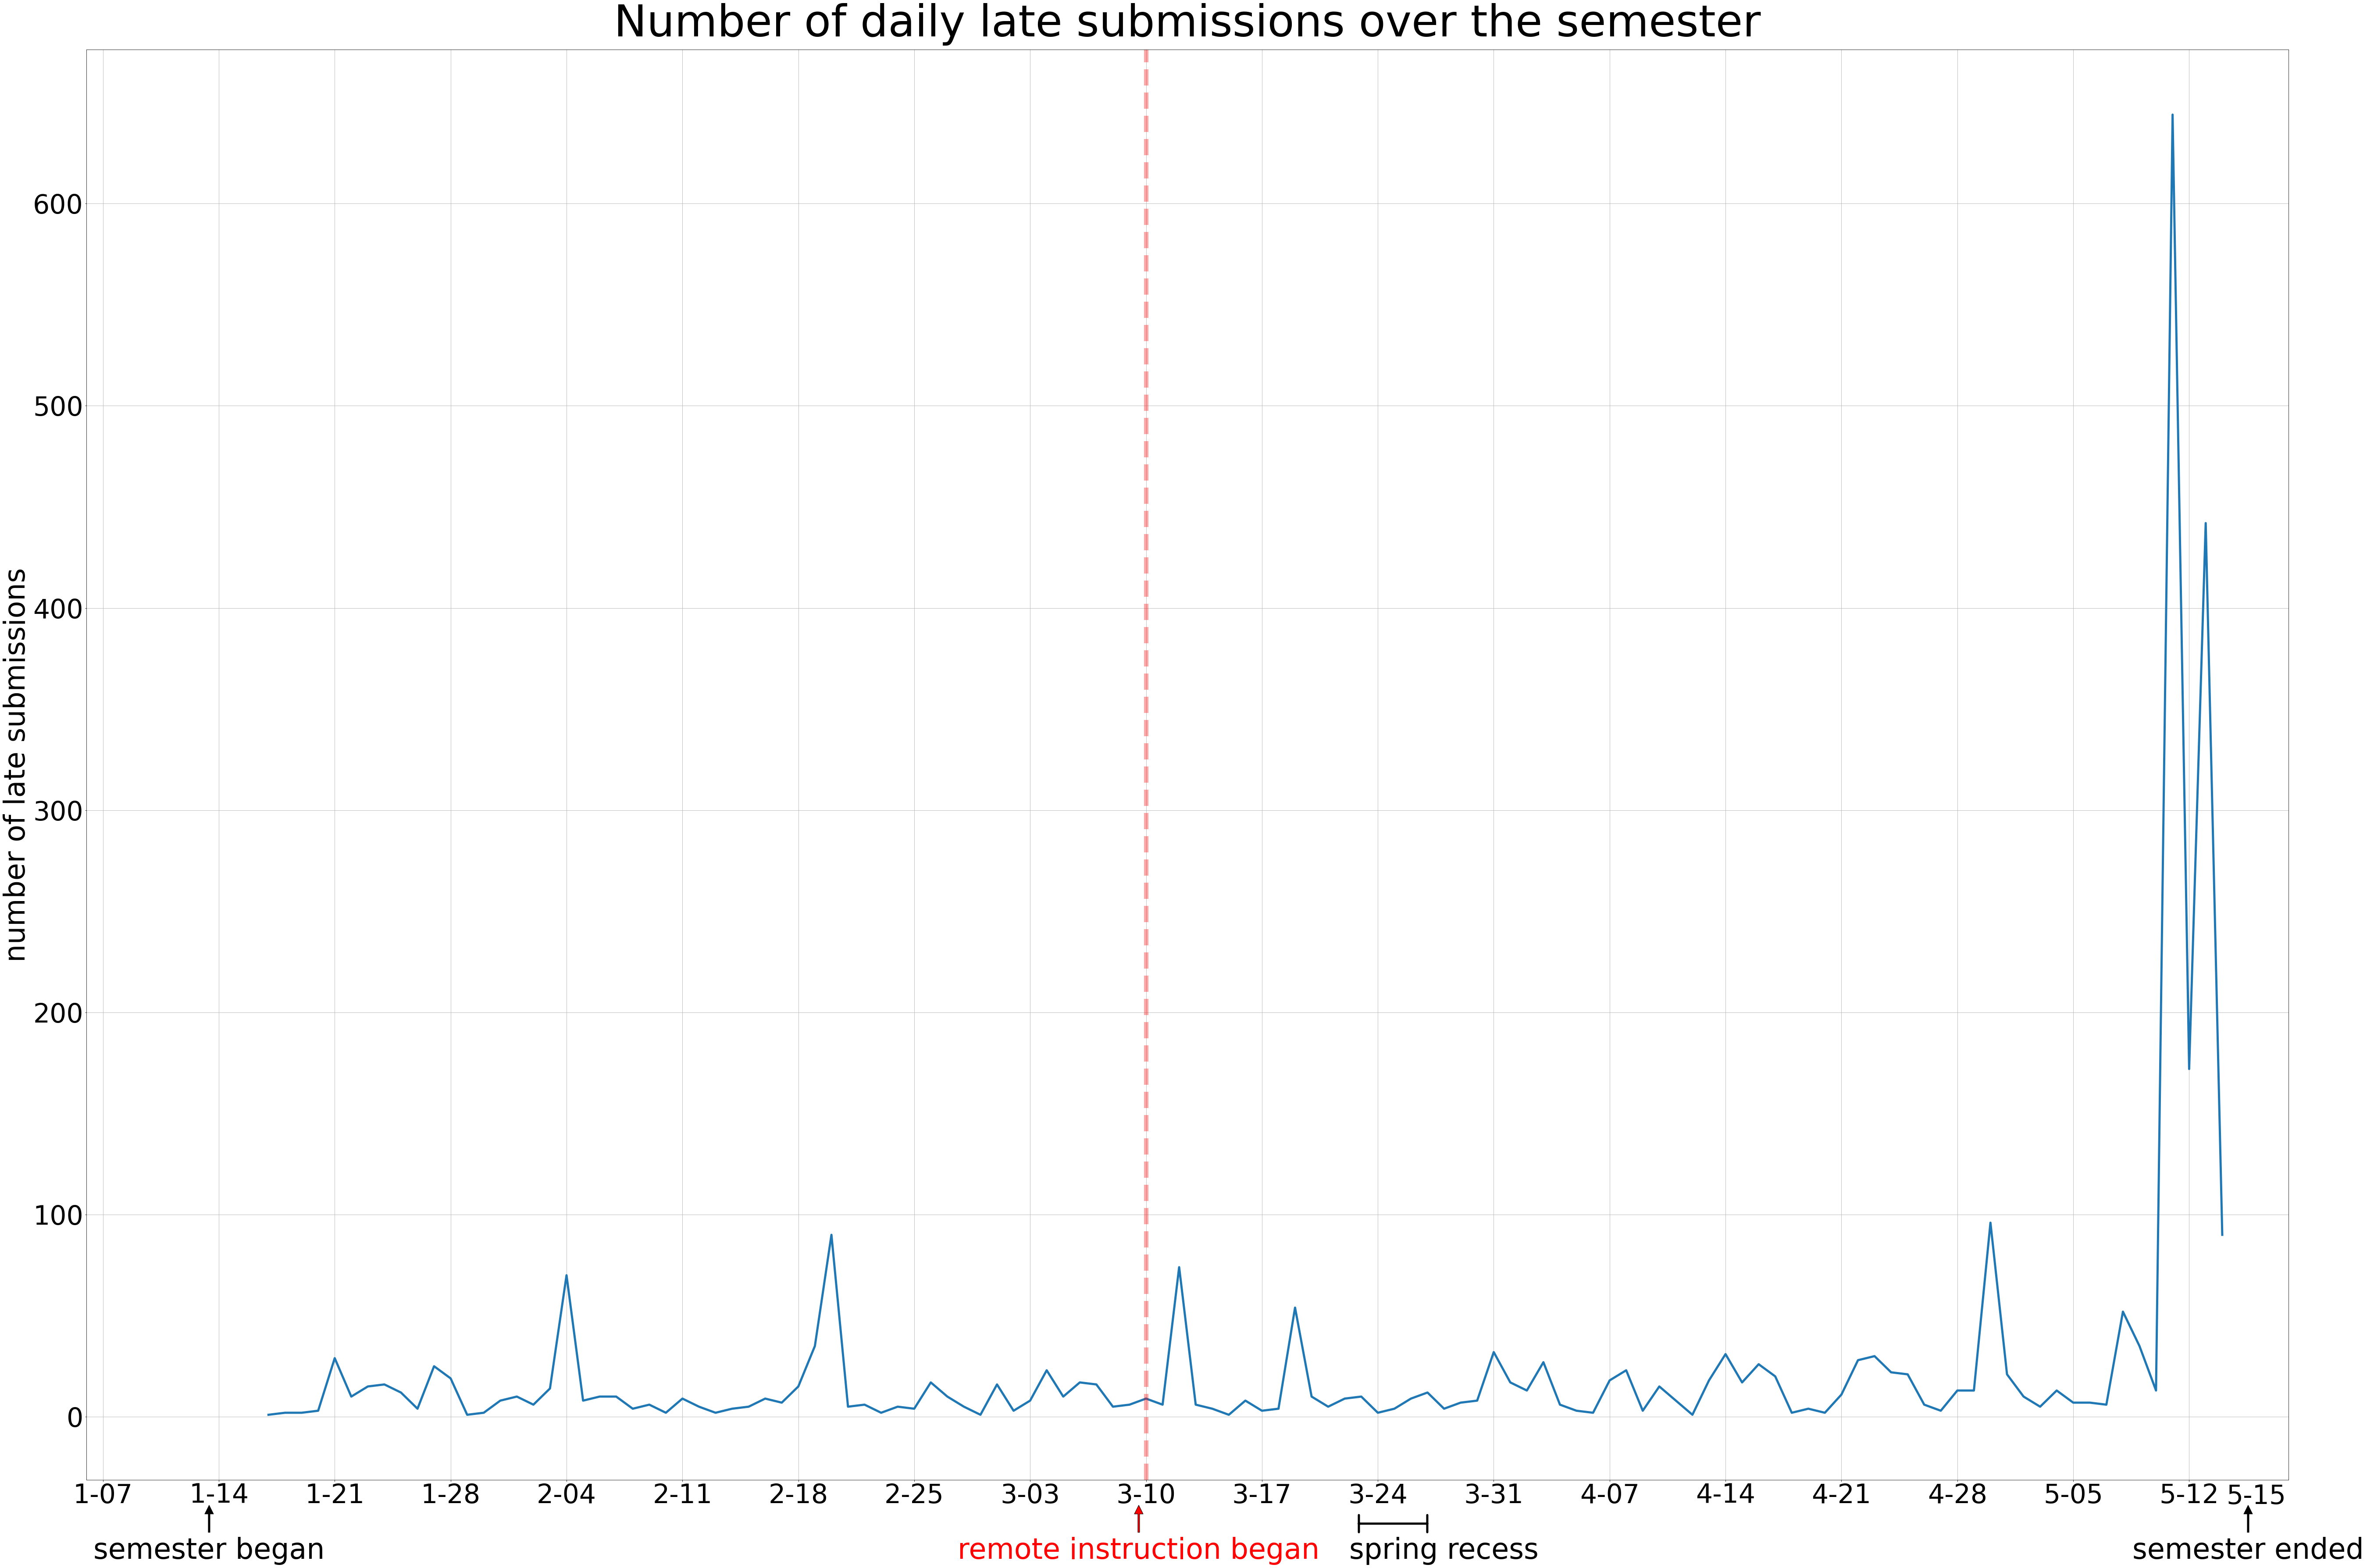

In [39]:

# set x-axis ticks
fig,ax = plt.subplots()
fig.patch.set_facecolor('white')
myFmt = mdates.DateFormatter('%-m-%d')
ax.xaxis.set_major_formatter(myFmt)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.set_xlim([datetime.date(2020, 1, 6), datetime.date(2020, 5, 18)])

plt.plot(late_20, linewidth=5.0, label='2020 Spring')
plt.plot(late_19, linewidth=5.0, label='2019 Spring', alpha=0)
plt.plot(late_18, linewidth=5.0, label='2018 Spring', alpha=0)
plt.plot(late_17, linewidth=5.0, label='2017 Spring', alpha=0)

plt.xticks(fontsize=60)
plt.yticks(fontsize=60)
plt.grid(True)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 90
fig_size[1] = 60
plt.rcParams["figure.figsize"] = fig_size
plt.title('Number of daily late submissions over the semester', fontsize=100, pad=30)
#plt.xlabel('date', fontsize=65, labelpad=120)
plt.ylabel('number of late submissions', fontsize=65)

# annotation on x-axis

ax.annotate('semester began', fontsize=65, xy=(280, -50), xytext=(280, -180), xycoords='axes points', ha='center',
           arrowprops=dict(facecolor='black', shrink=0.1, headlength=20, headwidth=20))
ax.annotate('remote instruction began', color='red', fontsize=65, xy=(2400, -50), xytext=(2400, -180), xycoords='axes points', ha='center', arrowprops=dict(facecolor='red', shrink=0.1, headlength=20, headwidth=20))
ax.annotate('semester ended', fontsize=65, xy=(4930, -50), xytext=(4930, -180), xycoords='axes points', ha='center', arrowprops=dict(facecolor='black', shrink=0.1, headlength=20, headwidth=20))
ax.annotate('5-15', fontsize=60, xy=(4880, -55), xycoords='axes points')

ax.annotate('', fontsize=65, xy=(2900, -100), xytext=(3060, -100),
            xycoords='axes points',
            arrowprops=dict(arrowstyle='|-|,widthA=0.3,widthB=0.3', linewidth=5))
ax.annotate('spring recess', fontsize=65, xy=(2880, -180), xycoords='axes points')
plt.axvline(x=datetime.date(2020, 3, 10), color = 'r', linewidth=10, alpha=0.35, linestyle='--')
#plt.legend(prop={'size': 70})
plt.show()